# COM3018 - Samuel Ivuerah (6779255)'s Experiment


## Models Explored
- Individual Model: Logistic Regression
- Shared Model: Random Forest




---


## Installation Commands

In [ ]:
!pip install matplotlib scikit-learn pandas numpy



---


## Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score,
    balanced_accuracy_score, matthews_corrcoef,
    confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Setup

*   Loading Datasets
*   Displaying Datasets
*   Separating features and the target
*   Defining target labels
*   Setting seeds for reproducibility




---


In [ ]:
# Load the training, validation, and testing datasets
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")
val_data = pd.read_csv("val_data.csv")

# Check the structure of the datasets
print("Training Data Overview:")
print(train_data.info())
print("\nValidation Data Overview:")
print(val_data.info())
print("\nTesting Data Overview:")
print(test_data.info())

# Check for missing values
print("\nMissing Values in Training Data:")
print(train_data.isnull().sum())
print("\nMissing Values in Validation Data:")
print(val_data.isnull().sum())
print("\nMissing Values in Testing Data:")
print(test_data.isnull().sum())

# Separating feature matrices and target vectors
X_train = train_data.drop(columns=['target'])
y_train = train_data['target']

X_val = val_data.drop(columns=['target'])
y_val = val_data['target']

X_test = test_data.drop(columns=['target'])
y_test = test_data['target']

# Define labels
labels = ['Negative', 'Hyperthyroidism', 'Hypothyroidism']

# Set Seed
seed = 42
np.random.seed(seed)

Training Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  771 non-null    int64  
 1   sex                  771 non-null    int64  
 2   on_thyroxine         771 non-null    int64  
 3   query_on_thyroxine   771 non-null    int64  
 4   on_antithyroid_meds  771 non-null    int64  
 5   sick                 771 non-null    int64  
 6   pregnant             771 non-null    int64  
 7   thyroid_surgery      771 non-null    int64  
 8   I131_treatment       771 non-null    int64  
 9   query_hypothyroid    771 non-null    int64  
 10  query_hyperthyroid   771 non-null    int64  
 11  lithium              771 non-null    int64  
 12  goitre               771 non-null    int64  
 13  tumor                771 non-null    int64  
 14  hypopituitary        771 non-null    int64  
 15  psych           



---


## Helper Functions

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_test, labels):
    """
    A function to evaluate a model on a test set and print metrics and a
    confusion matrix.

    :param model: A trained model
    :param X_test: The test set features
    :param y_test: The test set labels
    :param labels: The class labels
    """

    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)

    # Metrics (Weighted/Overall)
    precision = precision_score(y_test, predictions, average='weighted')
    recall = recall_score(y_test, predictions, average='weighted')
    f1 = f1_score(y_test, predictions, average='weighted')
    roc_auc = roc_auc_score(y_test, probabilities, multi_class='ovr')
    balanced_acc = balanced_accuracy_score(y_test, predictions)
    mcc = matthews_corrcoef(y_test, predictions)

    # Confusion Matrix for Specificity calculation
    conf_matrix = confusion_matrix(y_test, predictions)

    # Calculate class-specific metrics (Precision, Recall, F1)
    class_precision = precision_score(y_test, predictions, average=None, labels=[0, 1, 2])
    class_recall = recall_score(y_test, predictions, average=None, labels=[0, 1, 2])
    class_f1 = f1_score(y_test, predictions, average=None, labels=[0, 1, 2])

    # Specificity calculation for each class
    specificity = {}
    class_accuracy = {}
    for i in range(len(labels)):
        # Extract the confusion matrix for each class
        tn = conf_matrix.sum() - conf_matrix[i].sum() - conf_matrix[:, i].sum() + conf_matrix[i, i]
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        fn = conf_matrix[i].sum() - conf_matrix[i, i]
        tp = conf_matrix[i, i]

        specificity[labels[i]] = tn / (tn + fp) if (tn + fp) != 0 else 0
        # Calculate accuracy for each class
        class_accuracy[labels[i]] = tp / (tp + fp + fn) if (tp + fp + fn) != 0 else 0

    # Print metrics in a formatted manner
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Balanced Accuracy: {balanced_acc:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Specificity (for each class): {specificity}")
    print(f"Class Accuracy (for each class): {class_accuracy}")

    # Class-specific metrics (Precision, Recall, F1)
    for i, label in enumerate(labels):
        print(f"\nClass: {label}")
        print(f"  Precision: {class_precision[i]:.4f}")
        print(f"  Recall: {class_recall[i]:.4f}")
        print(f"  F1-Score: {class_f1[i]:.4f}")
        print(f"  Accuracy: {class_accuracy[label]:.4f}")

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_roc_curve(y_test, probabilities, labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(labels)):
        fpr, tpr, _ = roc_curve(y_test == i, probabilities[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='best')
    plt.show()

def plot_precision_recall_curve(y_test, probabilities, labels):
    plt.figure(figsize=(8, 6))
    for i in range(len(labels)):
        precision, recall, _ = precision_recall_curve(y_test == i, probabilities[:, i])
        plt.plot(recall, precision, label=f'{labels[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()




---
## Individual Model: Logistic Regression

### Hyperparameter Search

Using Gridsearch with 5 fold cross validation - ```GridSearchCV``` - via the ```sklearn.model_selection``` library.



#### Parameter Search Space

*   ```C``` - Regularisation Strength - ```[0.001, 0.01, 0.1, 1, 10, 100, 1000]```
   * Covering a large range of weak and strong regularisation to potentially minimise the overfitting of the majority classes (Hypothyroidism and Negative)
*   ```penalty``` - Regularisation Type - ```['l2', 'l1']```
   * Exploring L1 - Lasso - Regularisation and L2 - Ridge - Regularisation
*   ```solver``` - Optimisation Algorithm - ```['saga']```
   * Saga is a flexible and efficient solver, that can handle both l1 and l2 regularisation, and datasets with class imbalance.
*   ```max_iter``` - Maximum number of iterations - ```[100, 200, 1000]```
   * A wide range of iteration to ensure the solver has time for convergence.
*   ```class_weight``` - Class Imbalance Handling - ```[None, 'balanced']```
   * Where 'balanced' will automatically adjust weights based on class frequencies.
*   ```multi_class``` - Multiple Class Handling - ```['ovr', 'multinomial']```
   * There are three unique targets (Hyperthyroidism, Hypothyroidism, and Negative); hence, we have a multiclass classification problem, and thus, I will use suitable handling solution such as ovr - One vs rest - and multinomial.



In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1'],
    'solver': ['saga'],
    'max_iter': [5000],
    'class_weight': [None, 'balanced'],
    'multi_class': ['ovr', 'multinomial']
}

# Initialise Logistic Regression model
log_reg = LogisticRegression(random_state=seed)

# Set up GridSearchCV with 5 fold cross-validation
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy',
                           n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 5000, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.9104985337243402


### Best Hyperparameters Chosen

```
C=10
class_weight={0: 1, 1: 1.5, 2: 1}
max_iter=1000
multi_class='ovr'
penalty='l2'
solver='saga'
```

### Final Implementation

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Weighted Precision: 0.9175
Weighted Recall: 0.9147
Weighted F1-Score: 0.9147
ROC-AUC: 0.9632
Balanced Accuracy: 0.8855
Matthews Correlation Coefficient: 0.8563
Specificity (for each class): {'Negative': 0.9640287769784173, 'Hyperthyroidism': 0.9699570815450643, 'Hypothyroidism': 0.9305555555555556}
Class Accuracy (for each class): {'Negative': 0.8387096774193549, 'Hyperthyroidism': 0.625, 'Hypothyroidism': 0.9032258064516129}

Class: Negative
  Precision: 0.9541
  Recall: 0.8739
  F1-Score: 0.9123
  Accuracy: 0.8387

Class: Hyperthyroidism
  Precision: 0.7407
  Recall: 0.8000
  F1-Score: 0.7692
  Accuracy: 0.6250

Class: Hypothyroidism
  Precision: 0.9180
  Recall: 0.9825
  F1-Score: 0.9492
  Accuracy: 0.9032


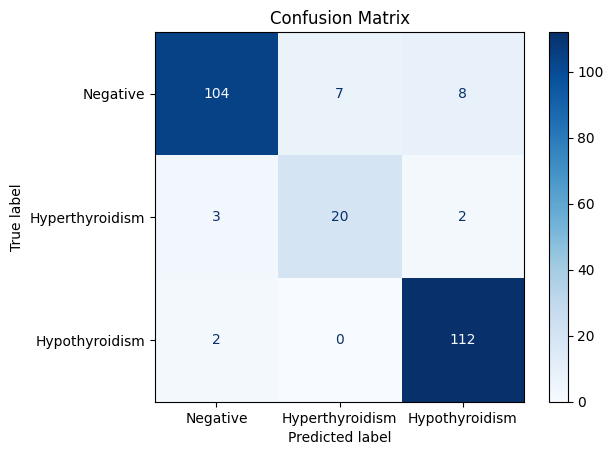

In [ ]:
# Initialise and train the Logistic Regression model
log_reg = LogisticRegression(
    C=0.1,
    class_weight='balanced',
    max_iter=5000,
    multi_class='ovr',
    penalty='l2',
    solver='saga',
    random_state=seed
)

# Fit the model on the training data
log_reg.fit(X_train, y_train)

# Evaluate the Logistic Regression model
evaluate_model(log_reg, X_test, y_test, labels=labels)




---


## Individual Model: Random Forest

### Hyperparameter Search

Using Gridsearch with 5-fold cross-validation - ```GridSearchCV``` - via the ```sklearn.model_selection``` library.

#### Parameter Search Space

*   ```n_estimators``` - Number of Trees - ```[100, 200, 300, 500]```
    * Exploring a range of tree counts, where more trees generally lead to more stable results but at the cost of increased computation time.
*   ```max_depth``` - Maximum Depth of Trees - ```[10, 20, 30, None]```
    * Limiting depth to reduce overfitting and ensure the model doesn't become too complex.
*   ```min_samples_split``` - Minimum Samples to Split - ```[2, 4, 8]```
    * Controls the minimum number of samples required to split an internal node. Higher values prevent the model from learning overly specific patterns.
*   ```min_samples_leaf``` - Minimum Samples at a Leaf - ```[1, 2, 4]```
    * Controls the minimum number of samples that must be present in a leaf node. This helps to generalize the model and avoid overfitting.
*   ```max_features``` - Number of Features to Consider for Each Split - ```[None, 'sqrt', 'log2']```
    * Varying how many features are considered at each split. Lower values help prevent overfitting by reducing the variance of the trees.
*   ```class_weight``` - Class Imbalance Handling - ```[None, 'balanced', {0: 1, 1: 1.5, 2: 1}]```
    * Adjusting class weights for imbalanced data, where **`'balanced'`** automatically adjusts the weight based on class frequency. The custom weight `{0: 1, 1: 1.5, 2: 1}` is used to give slightly more importance to Hyperthyroidism (class 1) due to its underrepresentation.
*   ```criterion``` - Quality of Split - ```['gini', 'entropy']```
    * Using 'gini' (default) or 'entropy' to measure the quality of a split. Both criteria are effective for classification tasks, but 'entropy' can be more sensitive to class distribution.


In [ ]:
# Define the parameter grid for Random Forest with custom class weights
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
    'criterion': ['gini', 'entropy']
}

# Instantiate Random Forest model with a random state for reproducibility
rf_model = RandomForestClassifier(random_state=seed)

# Set up GridSearchCV with 5-fold cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Output the best parameters and best score
print(f"Best Parameters: {grid_search_rf.best_params_}")
print(f"Best Score: {grid_search_rf.best_score_}")

Weighted Precision: 0.9544
Weighted Recall: 0.9535
Weighted F1-Score: 0.9532
ROC-AUC: 0.9889
Balanced Accuracy: 0.9347
Matthews Correlation Coefficient: 0.9208
Specificity (for each class): {'Negative': 0.9784172661870504, 'Hyperthyroidism': 0.9957081545064378, 'Hypothyroidism': 0.9444444444444444}
Class Accuracy (for each class): {'Negative': 0.9098360655737705, 'Hyperthyroidism': 0.8461538461538461, 'Hypothyroidism': 0.9262295081967213}

Class: Negative
  Precision: 0.9737
  Recall: 0.9328
  F1-Score: 0.9528
  Accuracy: 0.9098

Class: Hyperthyroidism
  Precision: 0.9565
  Recall: 0.8800
  F1-Score: 0.9167
  Accuracy: 0.8462

Class: Hypothyroidism
  Precision: 0.9339
  Recall: 0.9912
  F1-Score: 0.9617
  Accuracy: 0.9262


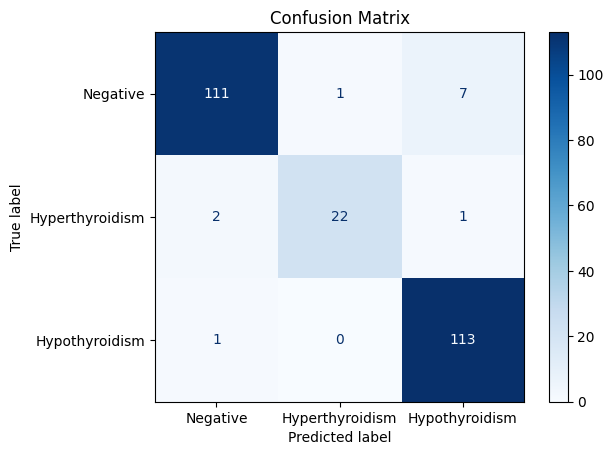

In [ ]:
# Initialise and train the Random Forest model with best parameters
rf_model = RandomForestClassifier(
    class_weight='balanced',
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=8,
    n_estimators=100,
    random_state=seed
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Evaluate the Random Forest model
evaluate_model(rf_model, X_test, y_test, labels=labels)
